##ThinkDSP

This notebook contains code solutions to exercises in Chapter 5: Autocorrelation

Copyright 2015 Allen Downey

License: [Creative Commons Attribution 4.0 International](http://creativecommons.org/licenses/by/4.0/)

In [2]:
from __future__ import print_function, division

import thinkdsp
import thinkplot
import thinkstats2

import numpy as np
import pandas as pd

%matplotlib inline

**Exercise:** If you did the exercises in the previous chapter, you downloaded
the historical price of BitCoins and estimated the power spectrum
of the price changes.  Using the same data, compute the autocorrelation
of BitCoin prices.  Does the autocorrelation function decay
exponentially?  Is there evidence of periodic behavior?

In [25]:
df = pd.read_csv('coindesk-bpi-USD-close.csv', nrows=1625, parse_dates=[0])
ys = df.Close.values

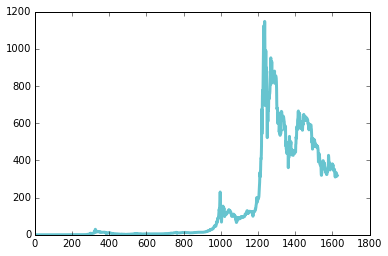

In [26]:
wave = thinkdsp.Wave(ys, framerate=1)
wave.plot()

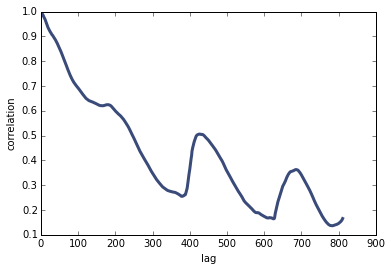

In [45]:
from autocorr import autocorr

lags, corrs = autocorr(wave)

thinkplot.preplot(5)
thinkplot.plot(lags, corrs)
thinkplot.config(xlabel='lag',
                 ylabel='correlation')

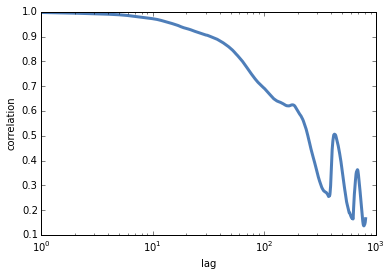

In [46]:
thinkplot.plot(lags, corrs)
thinkplot.config(xlabel='lag',
                 ylabel='correlation',
                 xscale='log')

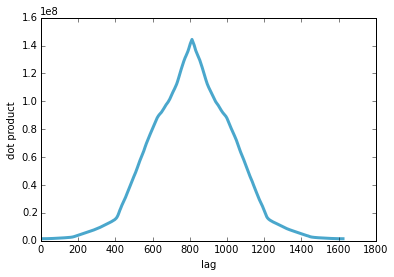

In [47]:
corrs2 = np.correlate(wave.ys, wave.ys, mode='same')
thinkplot.plot(corrs2)
thinkplot.config(xlabel='lag',
                 ylabel='dot product')

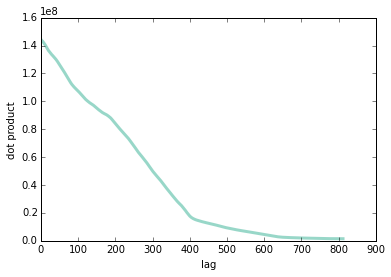

In [48]:
N = len(corrs2)
half = corrs2[N//2:]
thinkplot.plot(half)
thinkplot.config(xlabel='lag',
                 ylabel='dot product')

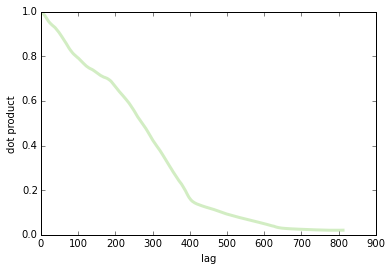

In [49]:
lengths = range(N, N//2, -1)
half /= lengths
half /= half[0]
thinkplot.plot(half)
thinkplot.config(xlabel='lag',
                 ylabel='dot product')

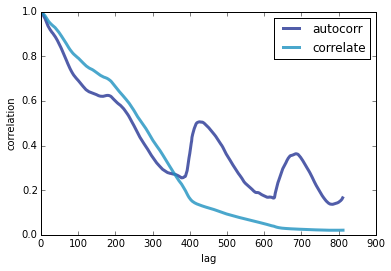

In [36]:
thinkplot.preplot(2)
thinkplot.plot(corrs, label='autocorr')
thinkplot.plot(half, label='correlate')
thinkplot.config(xlabel='lag', ylabel='correlation')

**Exercise:** The example code in `chap05.ipynb` shows how to use autocorrelation
to estimate the fundamental frequency of a periodic signal.
Encapsulate this code in a function called `estimate_fundamental`,
and use it to track the pitch of a recorded sound.

To see how well it works, try superimposing your pitch estimates on a
spectrogram of the recording.

In [51]:
wave = thinkdsp.read_wave('28042__bcjordan__voicedownbew.wav')
wave.normalize()
wave.make_audio()

I'll use the same example from `chap05.ipynb`.  Here's the spectrogram:

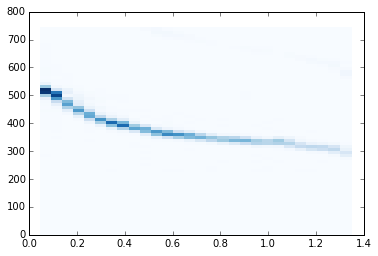

In [60]:
wave.make_spectrogram(4096).plot(high=70)

And here's a function that encapsulates the code from Chapter 5.  In general, finding the first, highest peak in the autocorrelation function is tricky.  I kept is simple by specifying the range of lags to search.

In [74]:
def estimate_fundamental(segment, low=70, high=150):
    lags, corrs = autocorr(segment)
    lag = np.array(corrs[low:high]).argmax() + low
    period = lag / segment.framerate
    frequency = 1 / period
    return frequency

Here's an example of how it works.

In [75]:
duration = 0.01
segment = wave.segment(start=0.2, duration=duration)
freq = estimate_fundamental(segment)
freq

436.63366336633663

And here's a loop that tracks pitch over the sample.

The `ts` are the mid-points of each segment.

In [93]:
step = 0.05
starts = np.arange(0.0, 1.4, step)

ts = []
freqs = []

for start in starts:
    ts.append(start + step/2)
    segment = wave.segment(start=start, duration=duration)
    freq = estimate_fundamental(segment)
    freqs.append(freq)

Here's the pitch-tracking curve superimposed on the spectrogram:

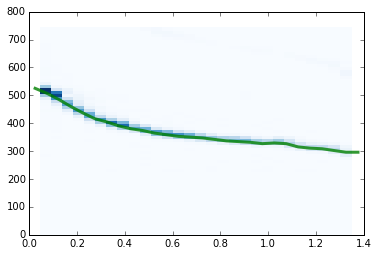

In [96]:
wave.make_spectrogram(4096).plot(high=70)
thinkplot.plot(ts, freqs, color='green')

Looks pretty good!